In [1]:
import numpy as np
import matplotlib.pyplot as plt

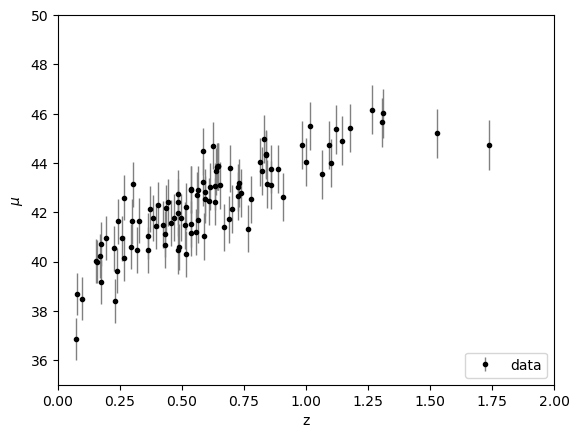

In [2]:
#Plot the data
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) ###YOU CAN'T CHANGE THIS

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel(r'$\mu$')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

In [3]:
#Reshape the data to ML use
z_sample = z_sample[:, np.newaxis]

# GPR fit

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp = GaussianProcessRegressor()
gp.fit(z_sample,mu_sample)

x_grid = np.linspace(0, 2, 100)
x_grid = x_grid[:, np.newaxis]

y_pred, dy_pred = gp.predict(x_grid, return_std=True)

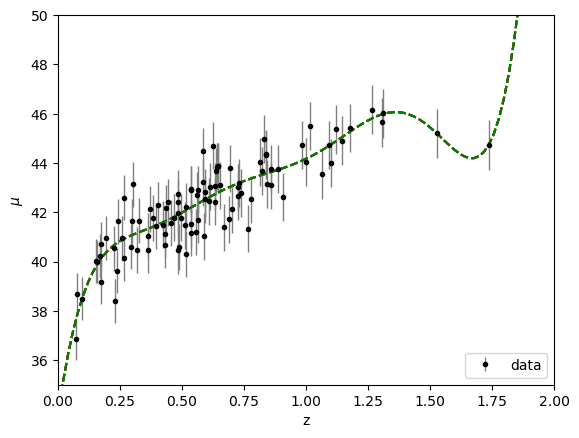

In [5]:
#Plot the data and the fit

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_grid, y_pred, linestyle='--') #Plot the fit

#Plot also 1-sigma → errors are too small to be distinguisehd
plt.plot(x_grid, (y_pred + dy_pred), linestyle='--', color = 'r') 
plt.plot(x_grid, (y_pred - dy_pred) , linestyle='--', color = 'r') 

#Plot also 2-sigma → errors are too small to be distinguisehd
plt.plot(x_grid, (y_pred + 2*dy_pred), linestyle='--', color = 'g') 
plt.plot(x_grid, (y_pred - 2*dy_pred) , linestyle='--', color = 'g') 

plt.xlabel("z")
plt.ylabel(r'$\mu$')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

plt.show()

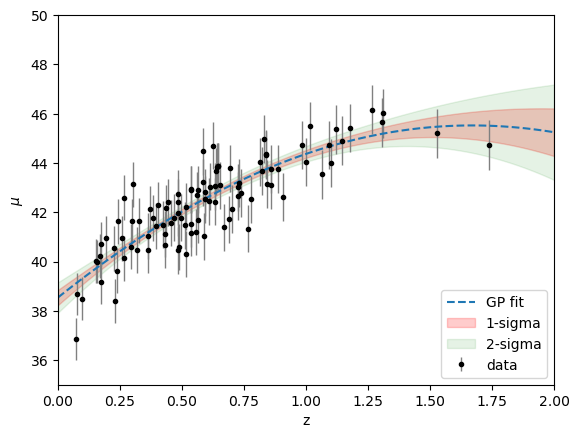

In [6]:
#Let's try a kernel mixture
from sklearn.gaussian_process.kernels import ConstantKernel, RBF


kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu ** 2, n_restarts_optimizer=10)

gp.fit(z_sample, mu_sample)
mu_fit, sigma = gp.predict(x_grid, return_std=True)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(x_grid, mu_fit, linestyle='--', label='GP fit')
plt.fill_between(x_grid.ravel(), mu_fit - sigma, mu_fit + sigma, color='r', alpha=0.2, label='1-sigma')
plt.fill_between(x_grid.ravel(), mu_fit - 2*sigma, mu_fit + 2*sigma, color='g', alpha=0.1, label='2-sigma')
plt.xlabel("z")
plt.ylabel(r'$\mu$')
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()

# Data cloning

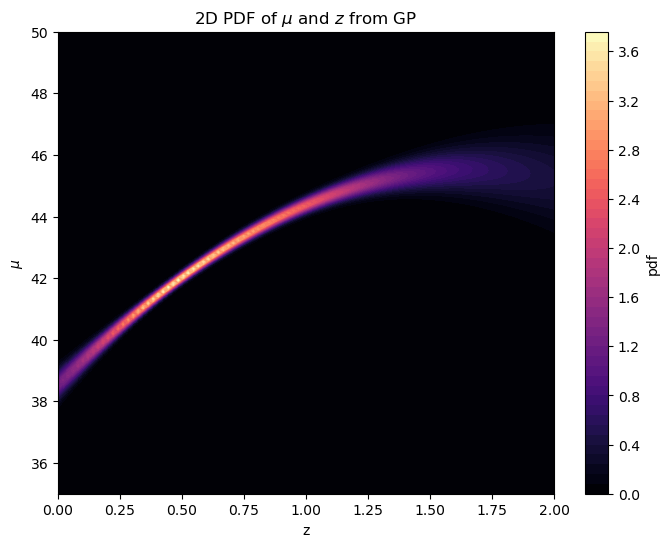

In [ ]:
#Plot the 2D pdf of mu and z
from scipy.stats import norm

#Create a grid for z and mu
z_grid = x_grid.ravel()
mu_grid = np.linspace(35, 50, 200)
Z, MU = np.meshgrid(z_grid, mu_grid)

#Compute the GP mean and std for each z
mu_mean = mu_fit
mu_std = sigma

#Compute the 2D pdf: for each z, pdf(mu|z) is Gaussian
PDF = norm.pdf(MU, loc=mu_mean[None, :], scale=mu_std[None, :])

plt.figure(figsize=(8, 6))
plt.contourf(Z, MU, PDF, levels=50, cmap='magma')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.title(r'2D PDF of $\mu$ and $z$ from GP')
plt.colorbar(label="pdf")

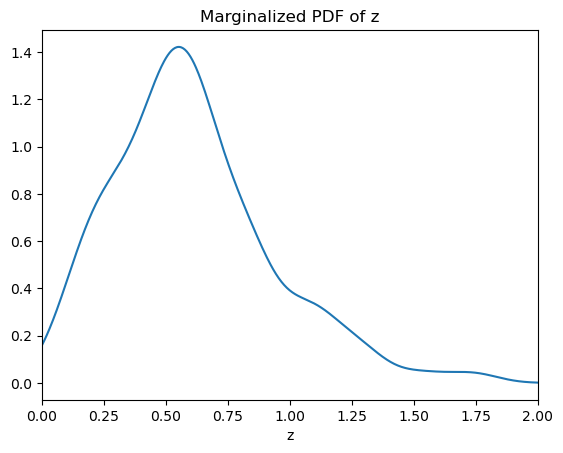

In [8]:
#Plot the projected PDF along z
from sklearn.neighbors import KernelDensity

z_vals = np.array(z_sample).reshape(-1, 1) 

kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(z_vals)

z_plot = np.linspace(z_vals.min() - 1, z_vals.max() + 1, 1000).reshape(-1, 1)
log_dens = kde.score_samples(z_plot)
dens = np.exp(log_dens)

plt.plot(z_plot[:, 0], dens)
plt.xlabel('z')
plt.title('Marginalized PDF of z')
plt.xlim(0, 2)
plt.show()

Text(0.5, 1.0, 'Cloned data')

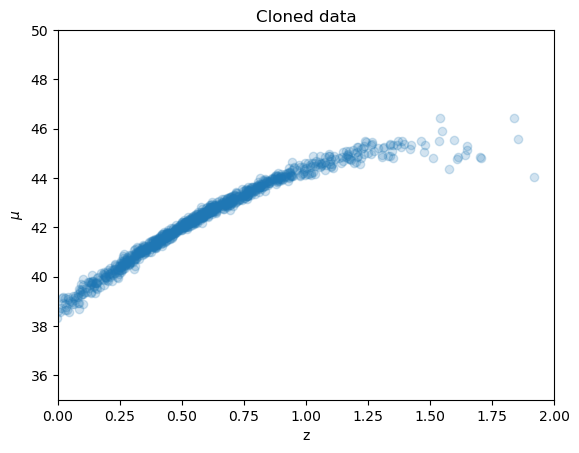

In [ ]:
#Clone the data
N = 1000
new_z_samples = kde.sample(N)

mu_gpr=[]
for z in np.squeeze(new_z_samples):    
    mu_fit, sigma = gp.predict([[z]], 
                           return_std=True)
    mu_gpr.append(np.random.normal(loc=mu_fit,scale=sigma))
    
    
plt.scatter(new_z_samples,mu_gpr,alpha=0.2)

plt.xlabel("z")
plt.ylabel(r'$\mu$')
plt.xlim(0,2)
plt.ylim(35,50)
plt.title("Cloned data")

# Cosmology

In [10]:
from astropy.cosmology import FlatLambdaCDM
import dynesty
from dynesty import plotting as dyplot

Let's try with nested sampling


In [11]:
#Assume a flat cosmology
def flatcosmo(par, x):
    H_0, om_m = par
    return FlatLambdaCDM(H0 = H_0, Om0 = om_m)

In [12]:
#Create the data for the nested sampling
data = [np.squeeze(z_sample), np.squeeze(mu_sample), np.squeeze(dmu)]

In [13]:
def logL(par, model=flatcosmo):
    x = data[0]
    y = data[1]
    yerr = data[2]
    mu_model = model(par, x).distmod(x).value
    return -0.5 * np.sum(np.power((y - mu_model) / yerr, 2))

In [14]:
#Set the ranges for the priors
H_0min,H_0max = 40, 100
om_mmin,om_mmax = 0.1, 1

In [15]:
def prior_transform(u):
    H_0 = H_0min + u[0] * (H_0max - H_0min)
    om_m = om_mmin + u[1] * (om_mmax - om_mmin)

    return np.array([H_0, om_m])

In [ ]:
#Perform nested sampling
ndim = 2
sampler = dynesty.NestedSampler(logL, prior_transform, ndim)
sampler.run_nested()
sresults = sampler.results

1626it [00:14, 110.94it/s, +500 | bound: 0 | nc: 1 | ncall: 12495 | eff(%): 17.724 | loglstar:   -inf < -46.385 <    inf | logz: -48.775 +/-  0.045 | dlogz:  0.001 >  0.509]


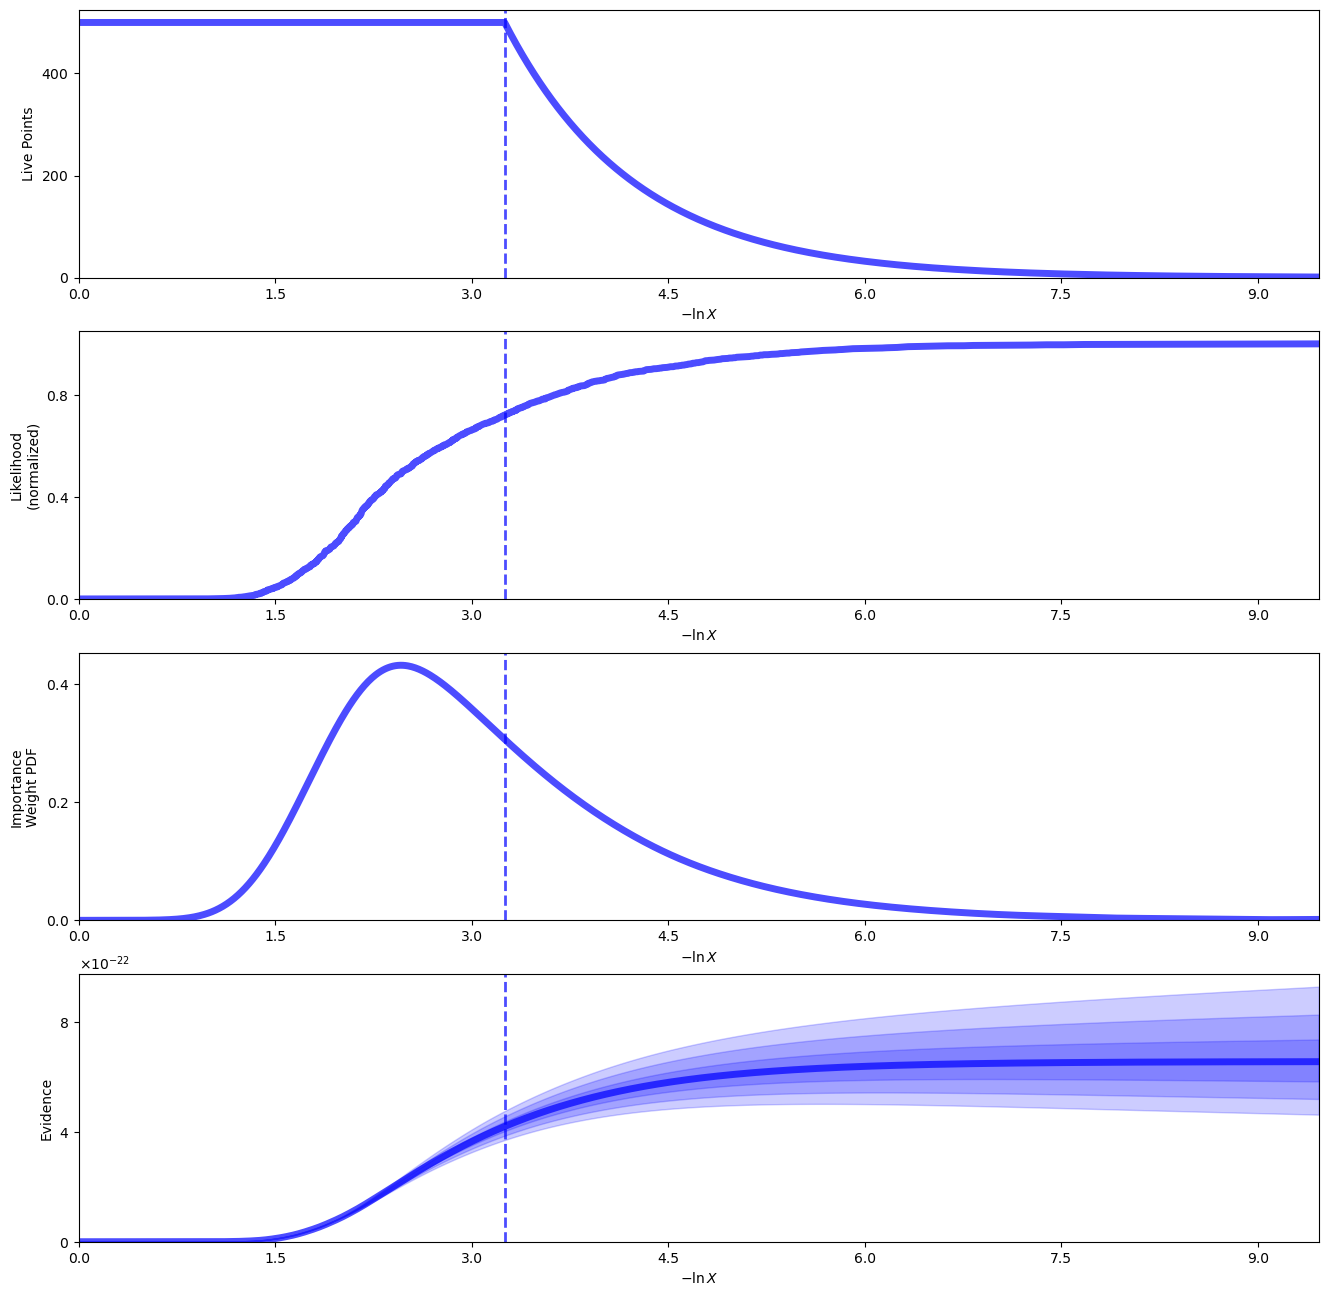

In [ ]:
#Plot a summary of the run
rfig, raxes = dyplot.runplot(sresults)

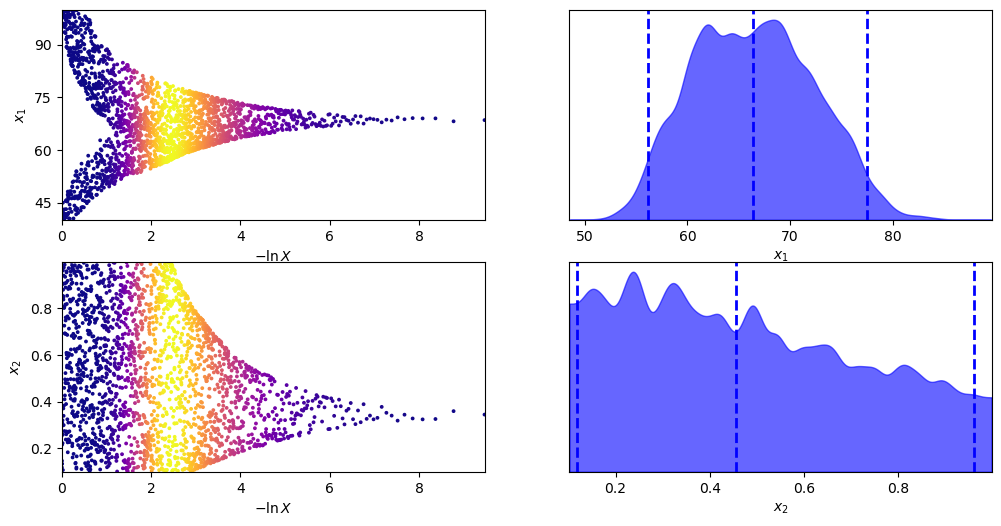

In [18]:
tfig, taxes = dyplot.traceplot(sresults)

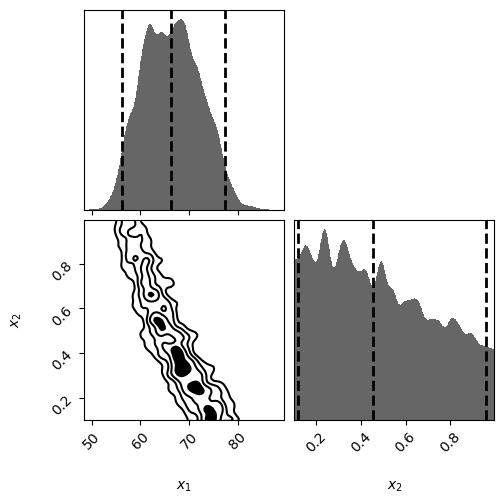

In [19]:
cfig, caxes = dyplot.cornerplot(sresults)

In [20]:
from dynesty import utils as dyfunc


#Extract sampling results
samples = sresults.samples  #samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  #normalised weights


evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

#Compute 10%-90% quantiles
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

#Compute weighted mean and covariance
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

Bayesian evidence 6.568741288884379e-22
68% parameter credible regions are:
 [[60.33267622204285, 72.61792180410536], [0.21387860974917597, 0.7848789398213505]]

Mean and covariance of parameters are: [66.44038756  0.48330643]
[[33.86903622 -1.23443088]
 [-1.23443088  0.06127106]]


In [21]:
#Print the obtained values for H_0 and om_m
print(f"H_0 = {mean[0]:.2f} +/- {np.sqrt(cov[0,0]):.2f}")
print(f"om_m = {mean[1]:.3f} +/- {np.sqrt(cov[1,1]):.3f}")


H_0 = 66.44 +/- 5.82
om_m = 0.483 +/- 0.248


In [22]:
#Save the bayesian evidence
b_evidence=[]
b_evidence.append(np.exp(evidence))

Use now a model without dark energy 

In [23]:
def noDEcosmo(par, x):
    H_0 = par
    return FlatLambdaCDM(H0 = H_0, Om0 = 1)

In [24]:
def noDE_prior_transform(u):
    H_0 = H_0min + u[0] * (H_0max - H_0min)

    return np.array([H_0])

In [25]:
def logL_1d(par, model=noDEcosmo):
    H0 = float(par[0])
    
    x = data[0]
    y = data[1]
    yerr = data[2]
    
    mu_model = model(H0, x).distmod(x).value
    return -0.5 * np.sum(((y - mu_model) / yerr)**2)

In [ ]:
#Perform nested sampling
ndim = 1
sampler = dynesty.NestedSampler(logL_1d, noDE_prior_transform, ndim)
sampler.run_nested()
sresults = sampler.results

1580it [00:12, 129.90it/s, +500 | bound: 0 | nc: 1 | ncall: 11765 | eff(%): 18.464 | loglstar:   -inf < -47.102 <    inf | logz: -49.357 +/-  0.036 | dlogz:  0.001 >  0.509]


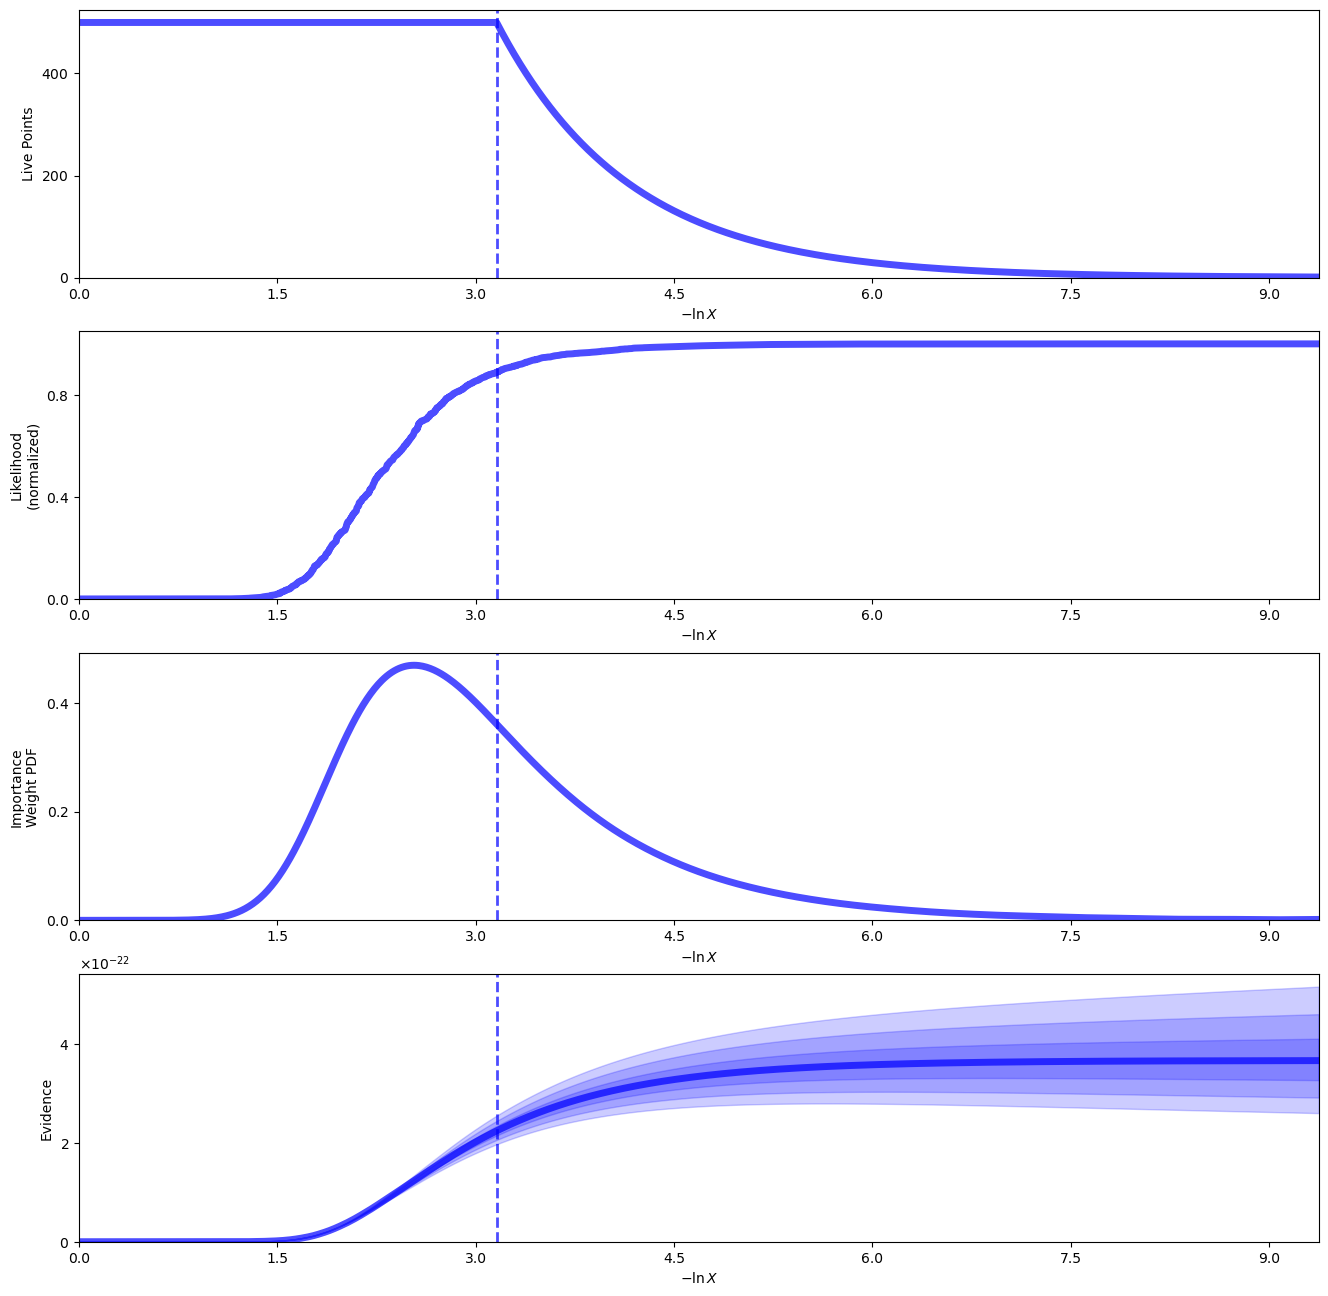

In [ ]:
#Plot a summary of the run
rfig, raxes = dyplot.runplot(sresults)

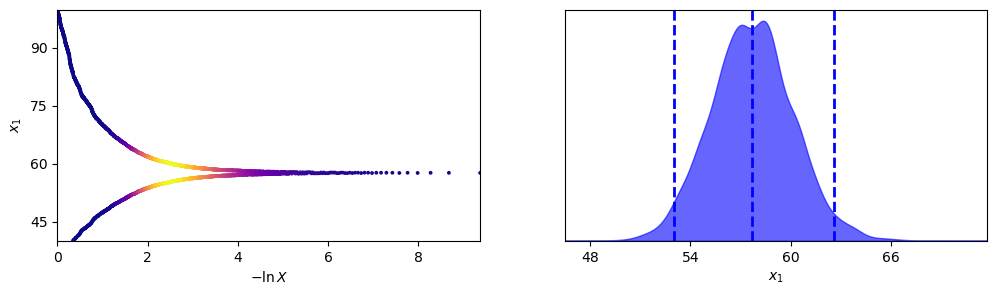

In [28]:
tfig, taxes = dyplot.traceplot(sresults)

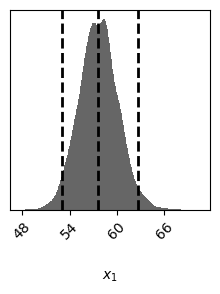

In [29]:
cfig, caxes = dyplot.cornerplot(sresults)

In [30]:
#Extract sampling results
samples = sresults.samples  #samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  #normalised weights


evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

#Compute 10%-90% quantiles
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

#Compute weighted mean and covariance
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

Bayesian evidence 3.670588510936782e-22
68% parameter credible regions are:
 [[55.26722600393661, 60.13457803454518]]

Mean and covariance of parameters are: [57.68047549]
[[5.92308497]]


In [31]:
#Print the obtained values for H_0 
print(f"H_0 = {mean[0]:.2f} +/- {np.sqrt(cov[0,0]):.2f}")

H_0 = 57.68 +/- 2.43


In [32]:
#Save the bayesian evidence
b_evidence.append(np.exp(evidence))

In [33]:
print("Bayes factor (No dark energy/ Dark energy):", b_evidence[1]/b_evidence[0])
print("The best model is the one with dark energy")

Bayes factor (No dark energy/ Dark energy): 0.5587963278669765
The best model is the one with dark energy
